# i_feat_relationships: Examining Feature Relationships Post Recommendations

**Description**: After establishing the recommender, looking further into relationships between features that I noticed during preprocessing and developing the cosine similarity matrix.

In [1]:
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import re
import seaborn as sns
from sqlalchemy import create_engine

%matplotlib inline

In [2]:
main_wfeats = pd.read_csv('../data/main_wfeats.csv', index_col='song_id')
gs = pd.read_csv('../data/gsong_lookup.csv', index_col='gs_id')

## 1. Creating Genre Lookup List

In order to eventually merge the genres into the master song listing, I've separated the genres from the artist table, and created a lookup table to match each song with the genres tied to the songs performing artist. 

In [13]:
df['genres'] = df['genres'].apply(lambda x: x.split(sep=','))
df['genres'] = df['genres'].apply(lambda x: [i.replace('[', '') for i in x])
df['genres'] = df['genres'].apply(lambda x: [i.replace(']', '') for i in x])
df['genres'] = df['genres'].apply(lambda x: [i.replace('\'', '') for i in x])
df['genres'] = df['genres'].apply(lambda x: [i.strip() for i in x])

In [14]:
df['genres'].loc[0]

['boy band', 'dance pop', 'europop', 'pop', 'post-teen pop']

### 1a. Separating Genres and Their Associated `artist_id` Into a Separate Dataframe

In [15]:
genre_per_artist = df[['genres', 'id']]

In [16]:
genre_per_artist.head()

,genres,id
0,"[boy band, dance pop, europop, pop, post-teen ...",6Ff53KvcvAj5U7Z1vojB5o
1,"[antiviral pop, comedy rock, comic]",1bDWGdIC2hardyt55nlQgG
2,"[alternative metal, nu metal, post-grunge, rap...",0REMf7H0VP6DwfZ9MbuWph
3,"[alternative rock, folk, folk-pop, lilith, mel...",0MBIKH9DjtBkv8O3nS6szj
4,"[boy band, dance pop, gangster rap, hip hop, h...",7urq0VfqxEYEEiZUkebXT4


### 1b. Dropping Non-Artists From `genre_per_artist`

In [103]:
non_artists = pd.read_csv('../data/non_artists.csv', index_col=0)
non_artists_id = non_artists['s_artist_id']

In [105]:
genre_todrop = genre_per_artist.query("id in @non_artists_id")

In [109]:
genre_per_artist.drop(labels=genre_todrop.index, inplace=True)

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


## 2. Feature Interactions

While getting general feature counts for certain features, like `genre` and `release year` are helpful to get the shape of the dataset, it's more helpful to look at the interaction between features which are numerical measurements of certain audio qualities, since that's exactly how the cosine matrix will be determing similarity.

There are additional plots done during EDA located within the `ii_supplemental_EDA` notebook.

### 2a. Looking at Audio Features Against One-Another

In [27]:
# Will be very helpful plotting colors as a third dimension
#https://stackoverflow.com/questions/4265546/python-round-to-nearest-05

def round_to(n, precision):
    correction = 0.5 if n >= 0 else -0.5
    return int( n/precision+correction ) * precision

##### Energy vs Loudness

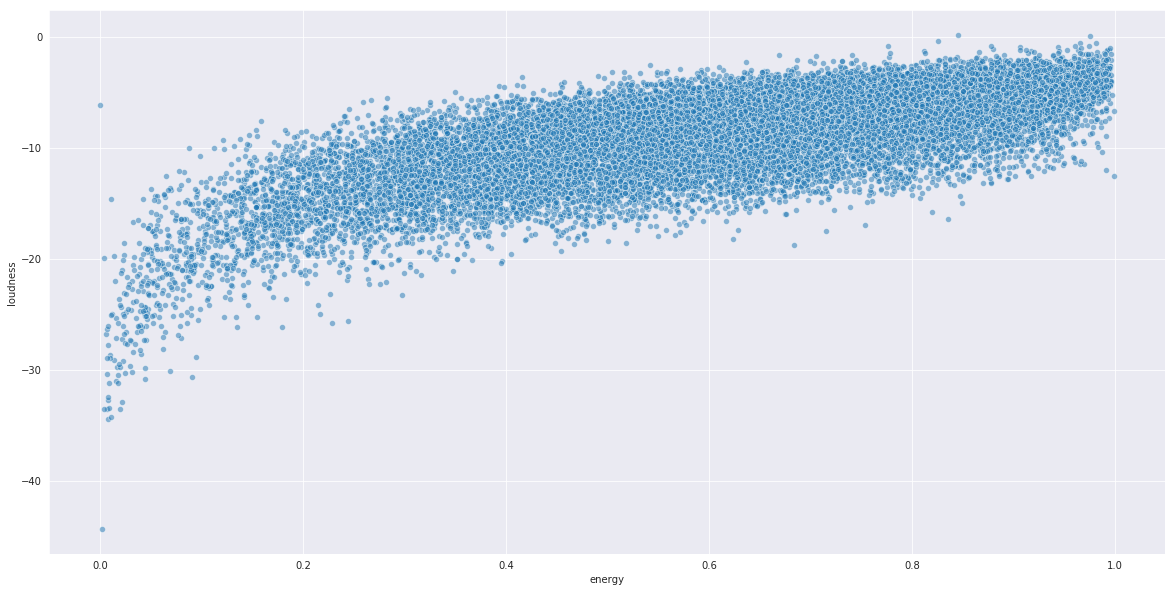

In [30]:
plt.figure(figsize=(20,10))
sns.scatterplot(main_wfeats['energy'], 
                main_wfeats['loudness'],
                alpha=0.5, palette='gist_heat', legend='full');

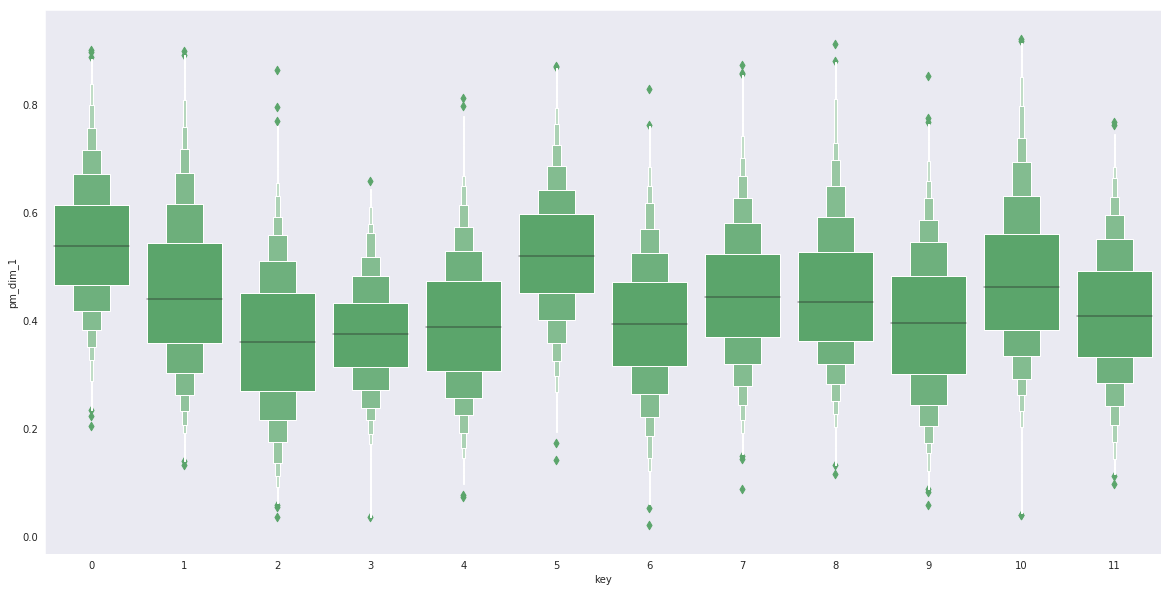

In [62]:
plt.figure(figsize=(20,10))
sns.boxenplot(x=main_wfeats['key'], y=main_wfeats['pm_dim_1'], color='#4eb264')

## 3: The Distribution of Songs with the `Most Distinctive Genres`

Sorting the dataset by what I've determined the as most distictive genres during Preprocessing. These are the genres which have the largest weights within the first 8 components of the genre matrix that I created, by tossing the genres into Singular Value Decomposition (or SVD).

I also have three categories for songs that have either:
 - more than one of the genres listed
 - songs that have none of the genres listed

##### Divvying Songs into `Most Distinct` Genres for Plotting

In [3]:
genres_dict = {'rock':[], 'rap':[], 'quiet storm':[], 'post-grunge':[],
               'country':[], 'dance pop':[]}
for song_id, genre in gs[['song_id', 'genre_name']].values:
    if genre in genres_dict.keys():
        genres_dict[genre].append(song_id)

In [4]:
gs[['song_id', 'genre_name']].values

array([['6SluaPiV04KOaRTOIScoff', 'dance pop'],
       ['6SluaPiV04KOaRTOIScoff', 'electropop'],
       ['6SluaPiV04KOaRTOIScoff', 'europop'],
       ...,
       ['09WwqFDqX2zv8rlvf4xYAk', 'nu metal'],
       ['09WwqFDqX2zv8rlvf4xYAk', 'post-grunge'],
       ['09WwqFDqX2zv8rlvf4xYAk', 'rock']], dtype=object)

In [5]:
def mdg_dict(x): 
    mdct = {} 
    for val in x: 
        mdct[val] = [] 
    return mdct

In [6]:
def mdg(x, gd):
    '''
    Find most distinct genre
    '''
    mdct = mdg_dict(x)
    merge_wdf = {}
    for val in x:
        for k, v in gd.items():
            if val in v:
                mdct[val].append(k)
    for song, genres in mdct.items():
        if len(genres) == 0:
            merge_wdf[song] = 'none'
        if len(genres) == 1:
            merge_wdf[song] = genres[0]
        if len(genres) >= 2:
            merge_wdf[song] = 'two or more'
    return merge_wdf

In [9]:
merge_wdf = mdg(main_wfeats.index, genres_dict)

In [10]:
merge_wdf = pd.Series(merge_wdf)

In [12]:
main_wfeats = main_wfeats.merge(pd.DataFrame(merge_wdf), left_on='song_id', right_on=merge_wdf.index)

In [13]:
main_wfeats.rename({0:'mdg'}, axis=1, inplace=True)

In [16]:
main_wfeats.drop('Unnamed: 0', 1, inplace=True)

### Good Figure Dimensions: (30,15) -w- 30 size tick labels

### Timbre Dimensions Spread Over Most Distinctive Genres

#### Timbre Mean Dimension 1 Spread Across Genres

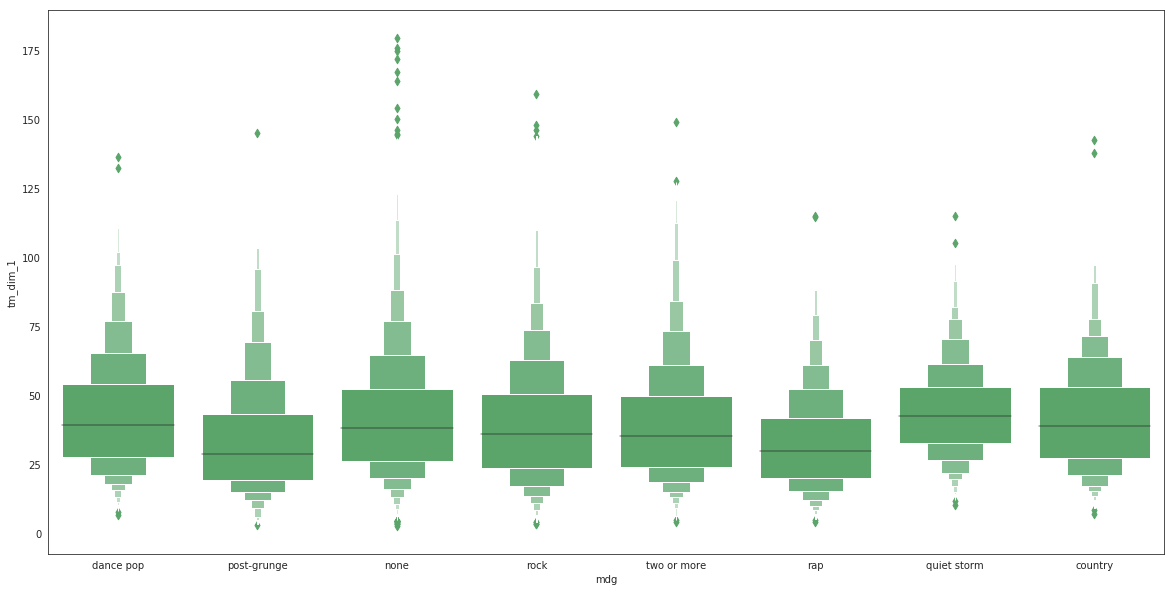

In [17]:
plt.figure(figsize=(20,10))
sns.set_style('white')
sns.boxenplot(main_wfeats['mdg'], 
              main_wfeats['tm_dim_1'],
              color='#4eb264');

#### Timbre Mean Dimension 2 Spread Across Genres

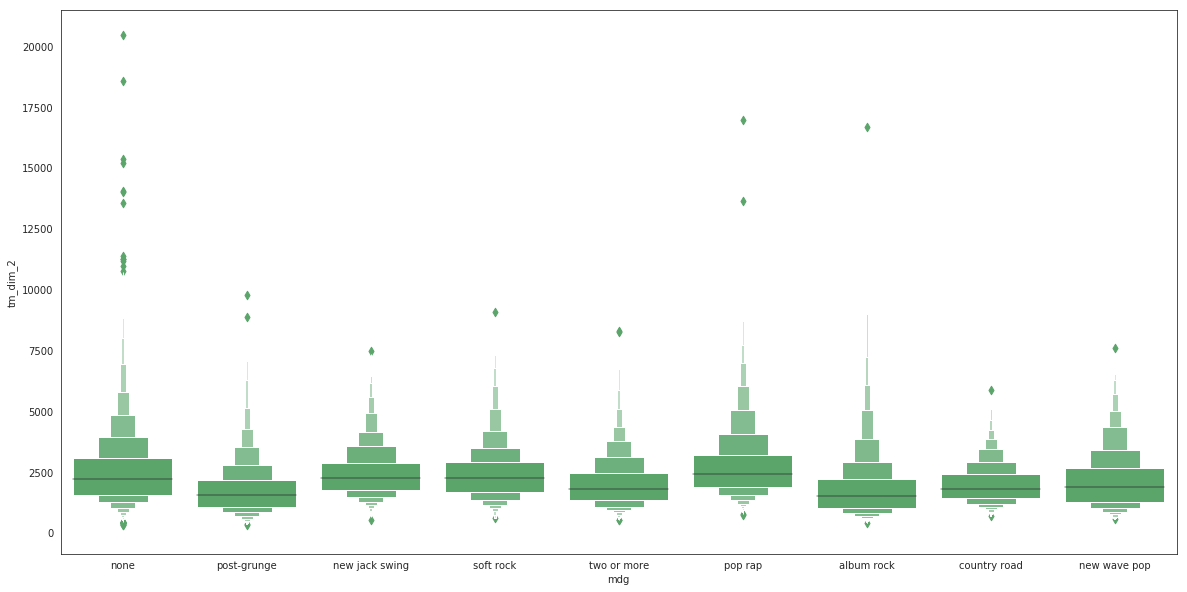

In [85]:
plt.figure(figsize=(20,10))
sns.set_style('white')
sns.boxenplot(main_wfeats['mdg'], 
              main_wfeats['tm_dim_2'],
              color='#4eb264');

#### Timbre Mean Dimension 3 Spread Across Genres

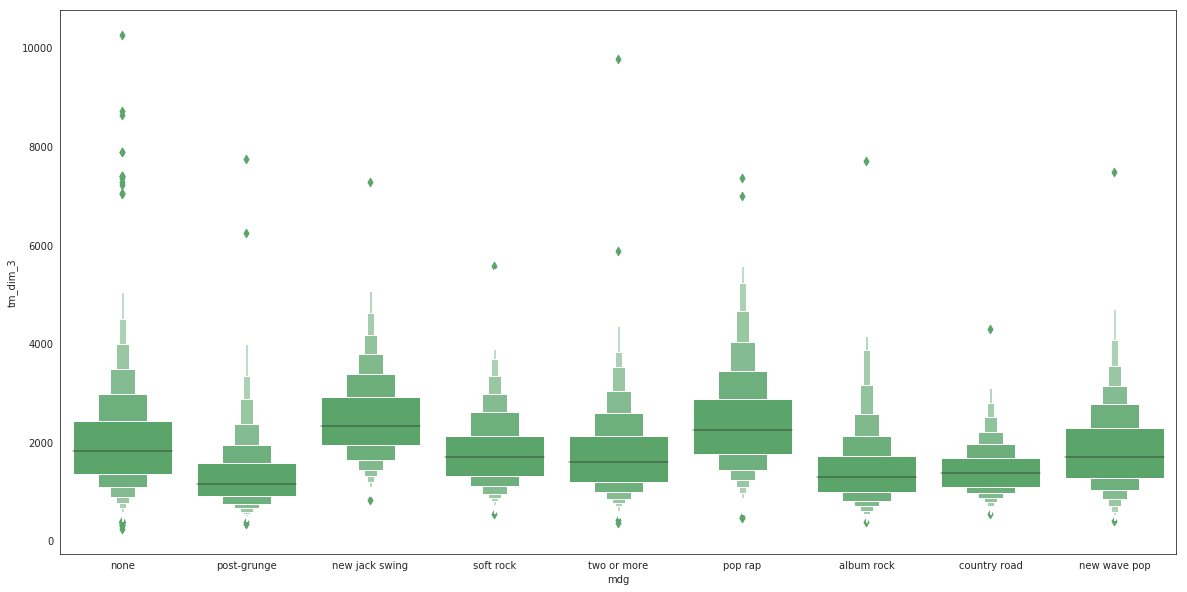

In [86]:
plt.figure(figsize=(20,10))
sns.set_style('white')
sns.boxenplot(main_wfeats['mdg'], 
              main_wfeats['tm_dim_3'],
              color='#4eb264');

#### Timbre Mean Dimension 4 Spread Across Genres

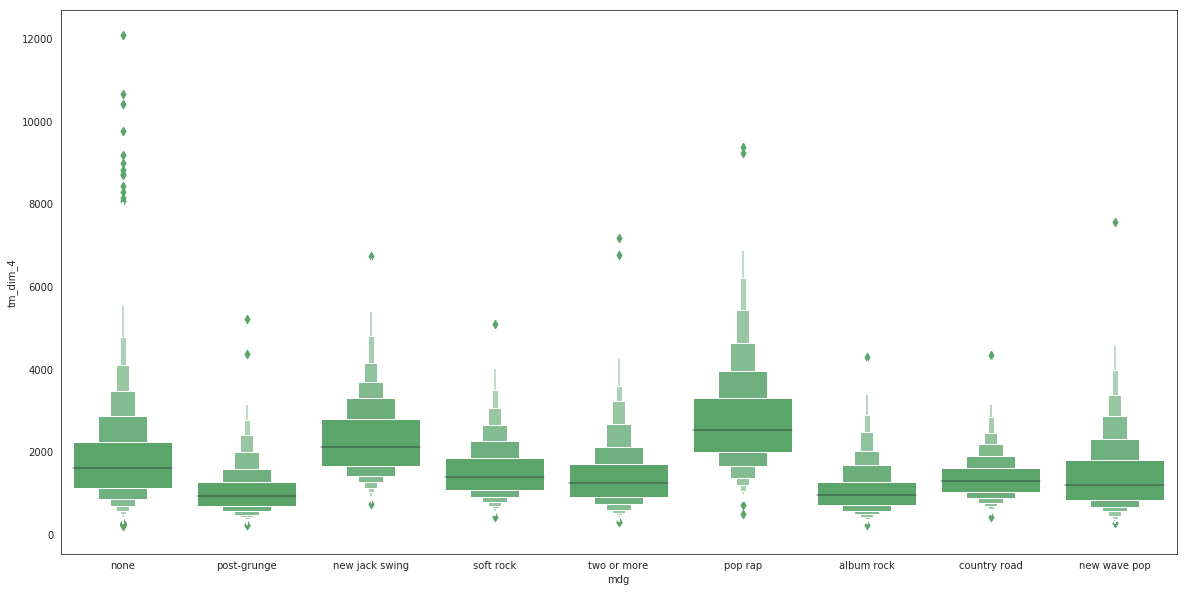

In [87]:
plt.figure(figsize=(20,10))
sns.set_style('white')
sns.boxenplot(main_wfeats['mdg'], 
              main_wfeats['tm_dim_4'],
              color='#4eb264');

#### Timbre Mean Dimension 5 Spread Across Genres

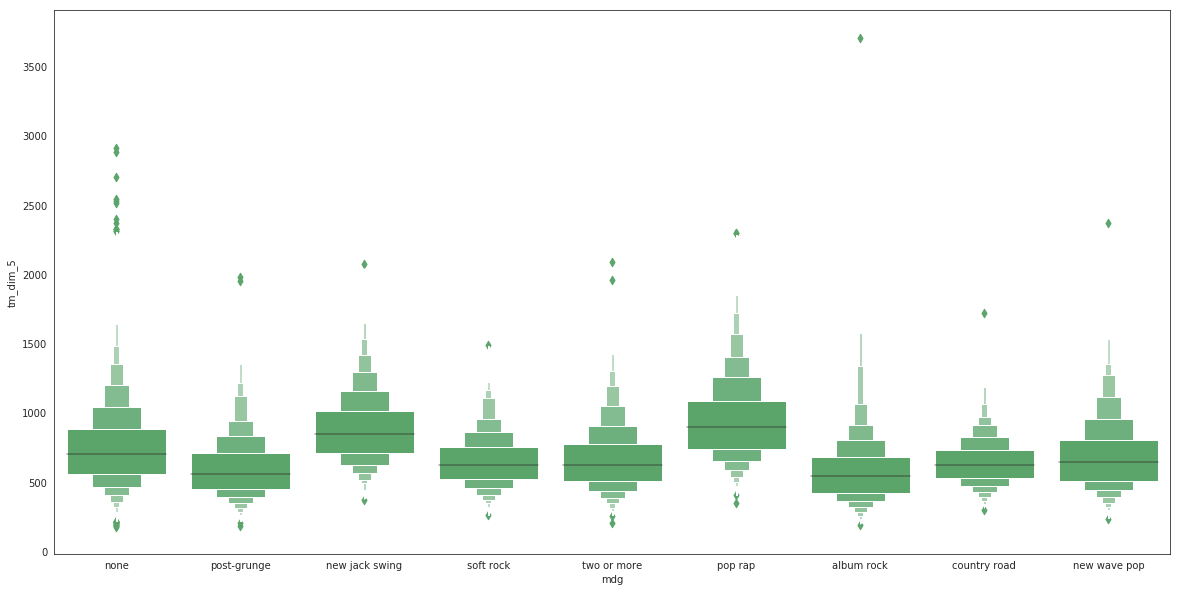

In [88]:
plt.figure(figsize=(20,10))
sns.set_style('white')
sns.boxenplot(main_wfeats['mdg'], 
              main_wfeats['tm_dim_5'],
              color='#4eb264');

#### Timbre Mean Dimension 6 Spread Across Genres

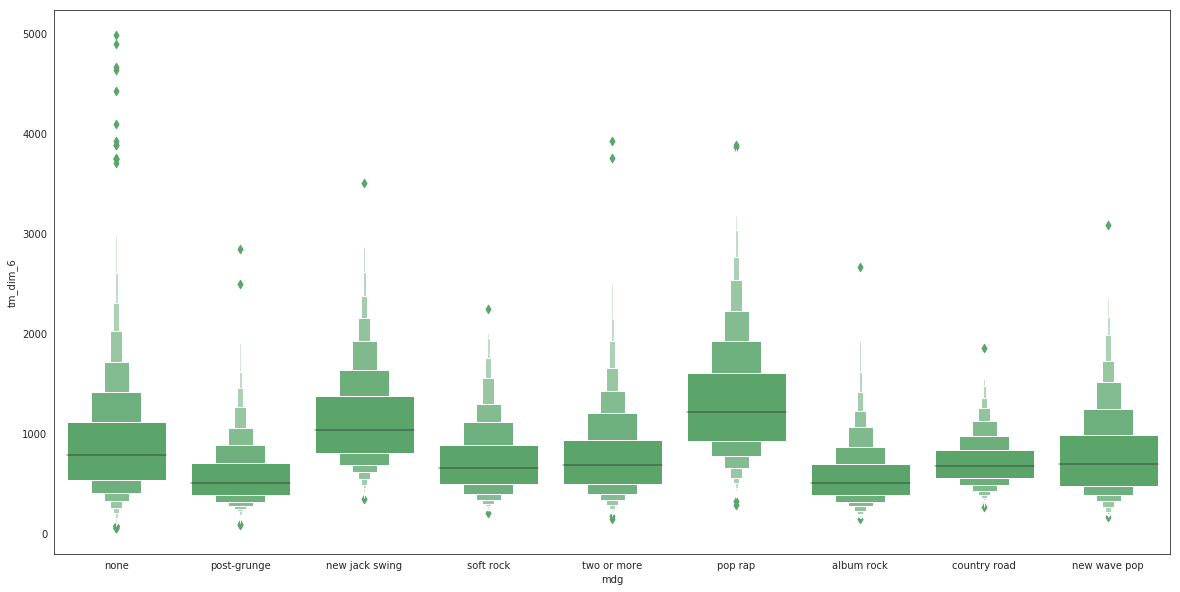

In [82]:
plt.figure(figsize=(20,10))
sns.set_style('white')
sns.boxenplot(main_wfeats['mdg'], 
              main_wfeats['tm_dim_6'],
              color='#4eb264');

#### Timbre Mean Dimension 7 Spread Across Genres

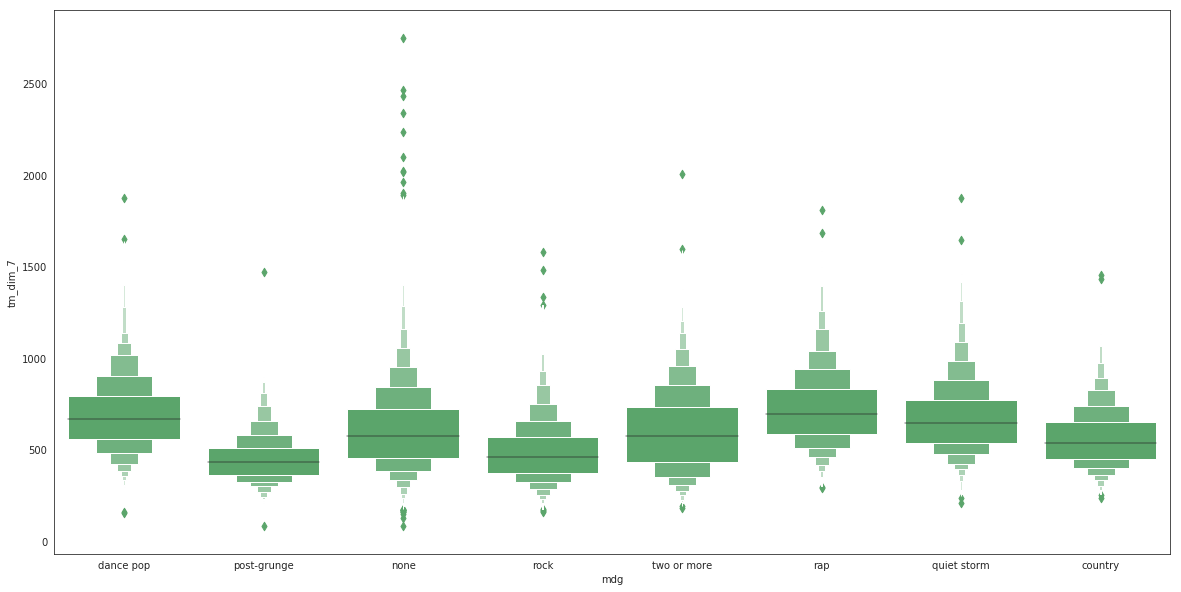

In [18]:
plt.figure(figsize=(20,10))
sns.set_style('white')
sns.boxenplot(main_wfeats['mdg'], 
              main_wfeats['tm_dim_7'],
              color='#4eb264');

#### Timbre Mean Dimension 8 Spread Across Genres

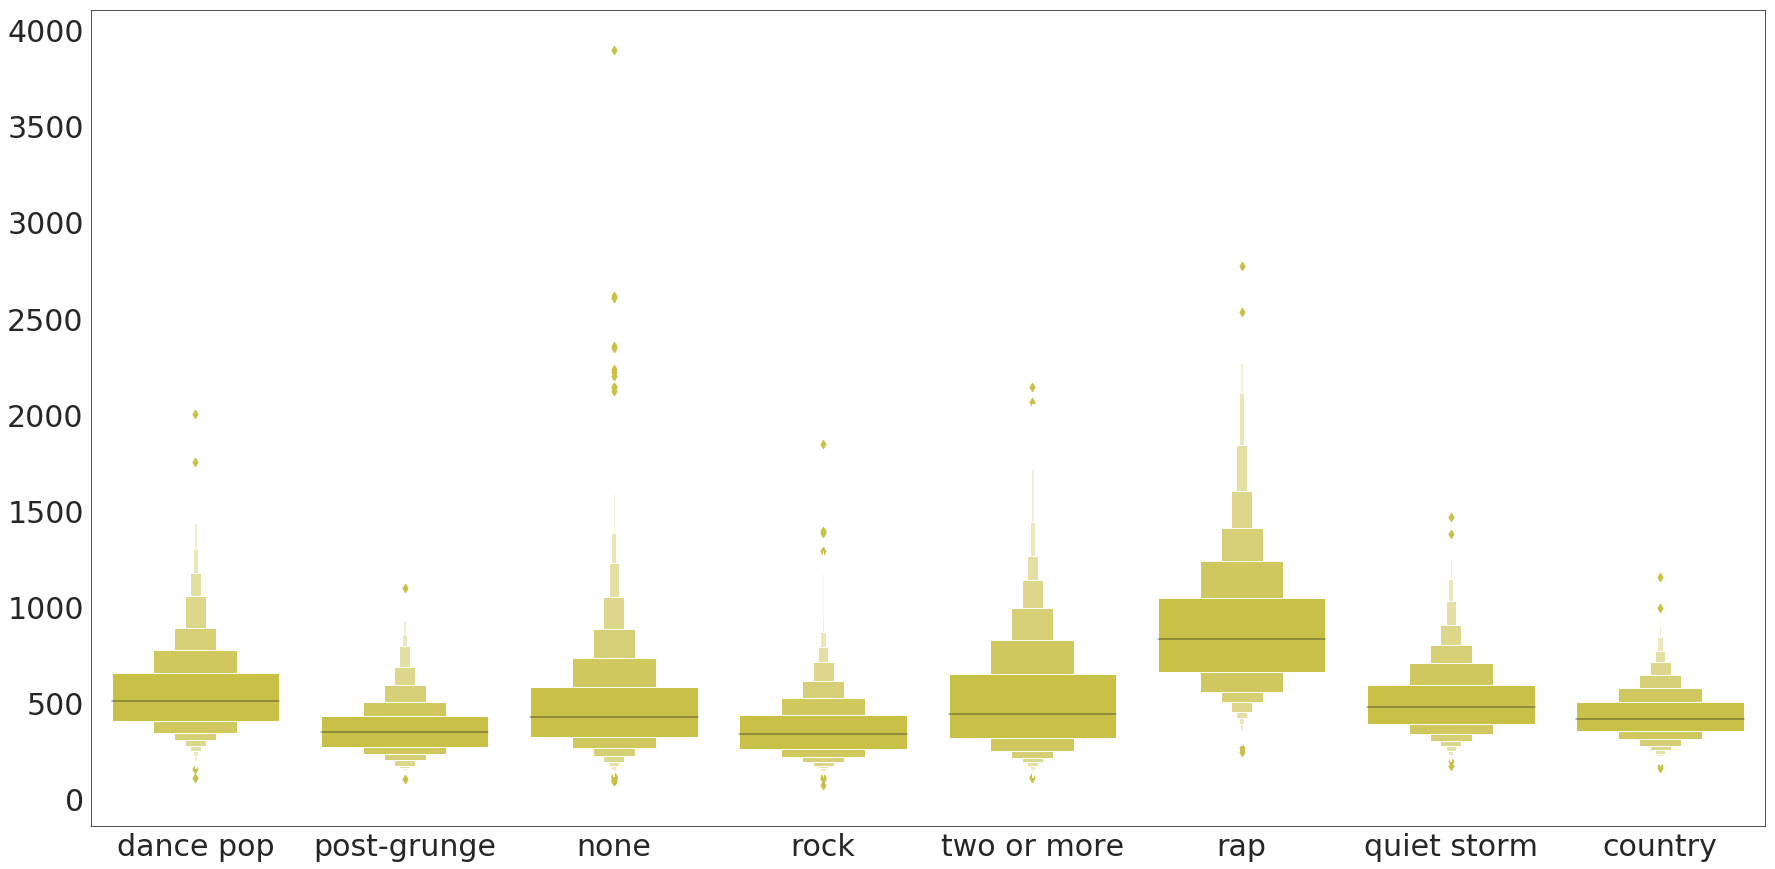

In [71]:
plt.figure(figsize=(20,10))
sns.set_style('white')
sns.boxenplot(main_wfeats['mdg'], 
              main_wfeats['tm_dim_8'],
              color='#dfd232')
plt.xticks(size=30)
plt.yticks(size=30)
plt.xlabel('Genres', size=20)
plt.ylabel('Bounce', size=20)
# plt.savefig('../images/bounce_genres.png', transparent=True);

#### Timbre Mean Dimension 9 Spread Across Genres

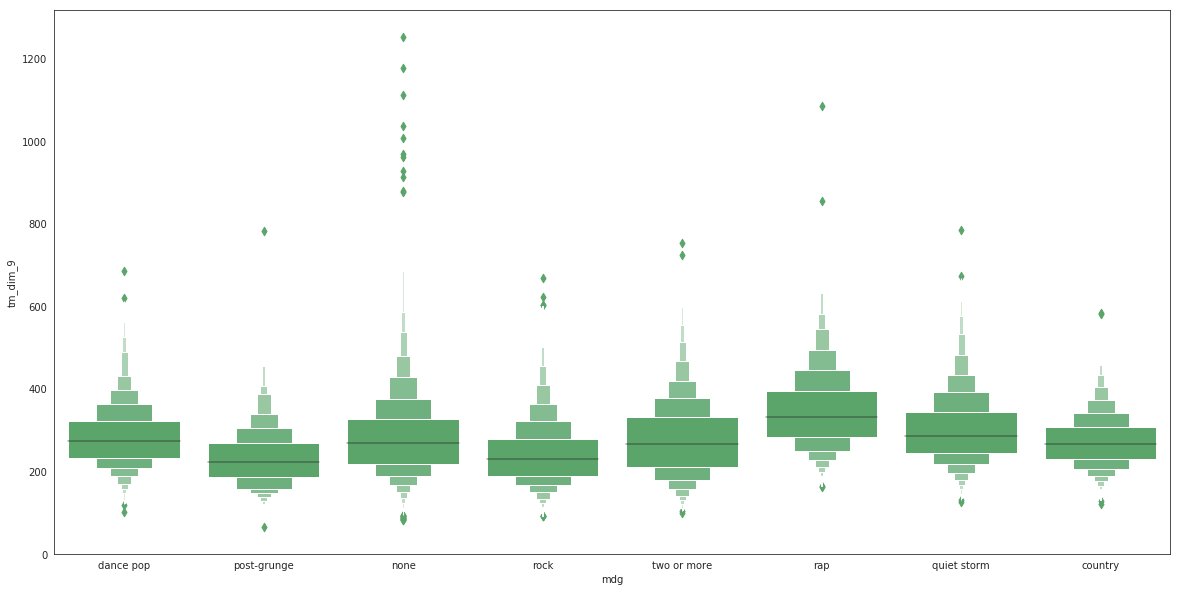

In [58]:
plt.figure(figsize=(20,10))
sns.set_style('white')
sns.boxenplot(main_wfeats['mdg'], 
              main_wfeats['tm_dim_9'],
              color='#4eb264');

#### Timbre Mean Dimension 10 Spread Across Genres

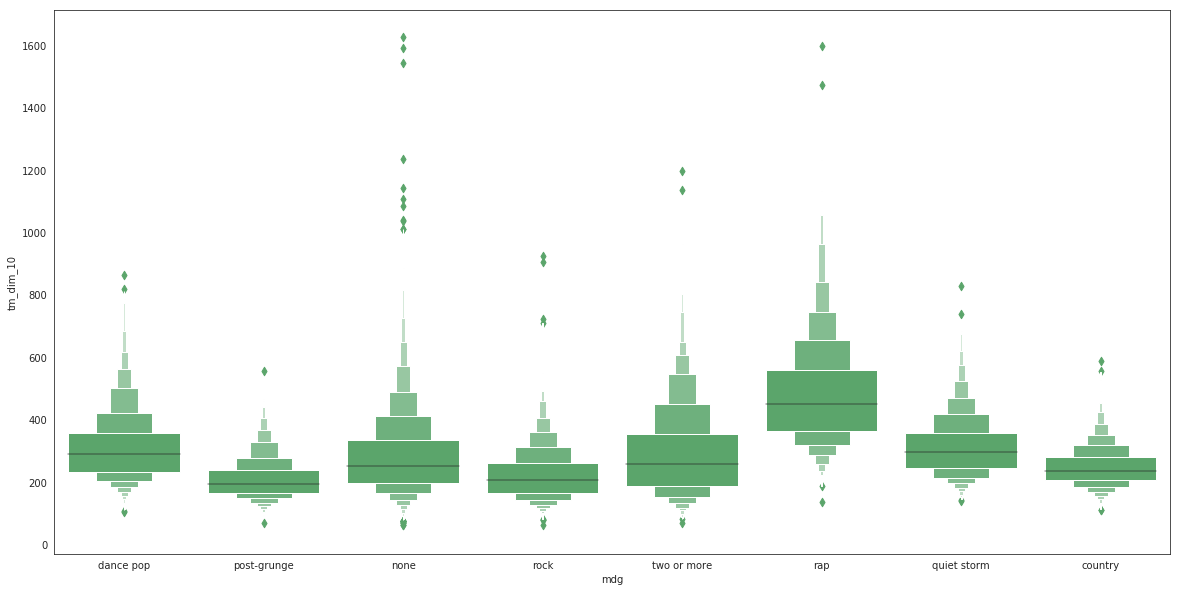

In [59]:
plt.figure(figsize=(20,10))
sns.set_style('white')
sns.boxenplot(main_wfeats['mdg'], 
              main_wfeats['tm_dim_10'],
              color='#4eb264');

#### Timbre Mean Dimension 11 Spread Across Genres

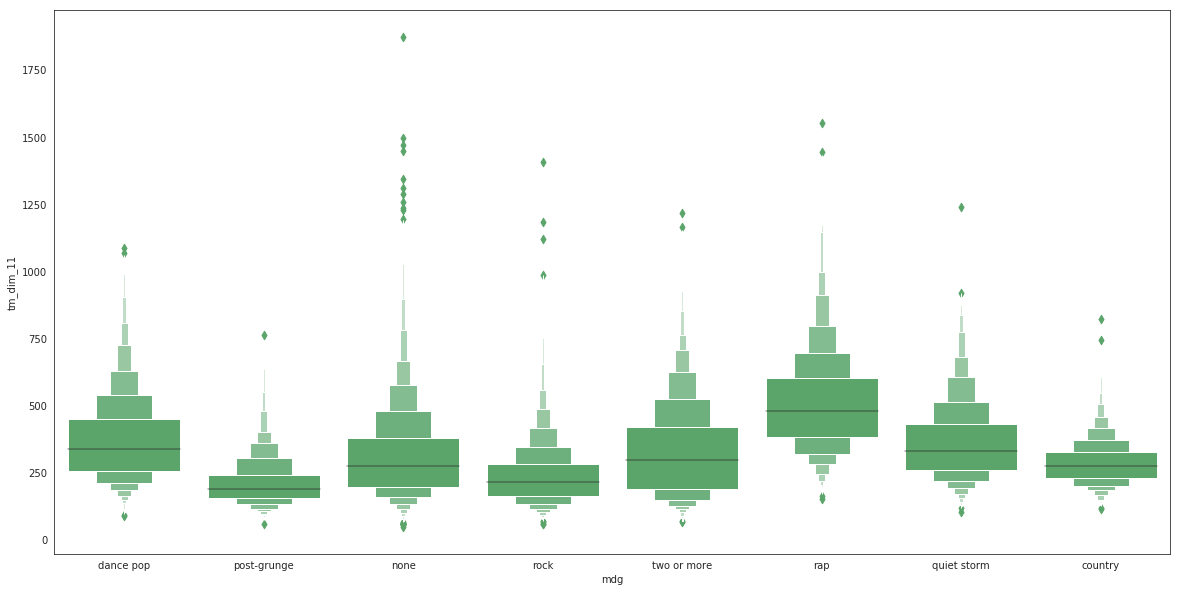

In [60]:
plt.figure(figsize=(20,10))
sns.set_style('white')
sns.boxenplot(main_wfeats['mdg'], 
              main_wfeats['tm_dim_11'],
              color='#4eb264');

#### Timbre Mean Dimension 12 Spread Across Genres

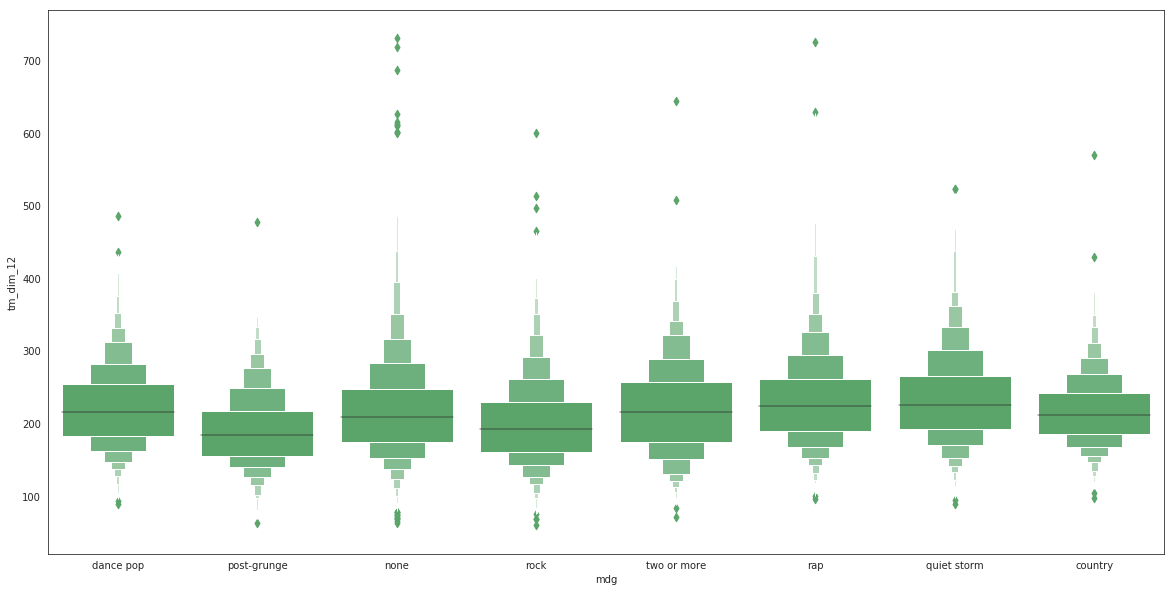

In [61]:
plt.figure(figsize=(20,10))
sns.set_style('white')
sns.boxenplot(main_wfeats['mdg'], 
              main_wfeats['tm_dim_12'],
              color='#4eb264');

##### Timbre Dimension 11 Mean Over Most Distinct Genre

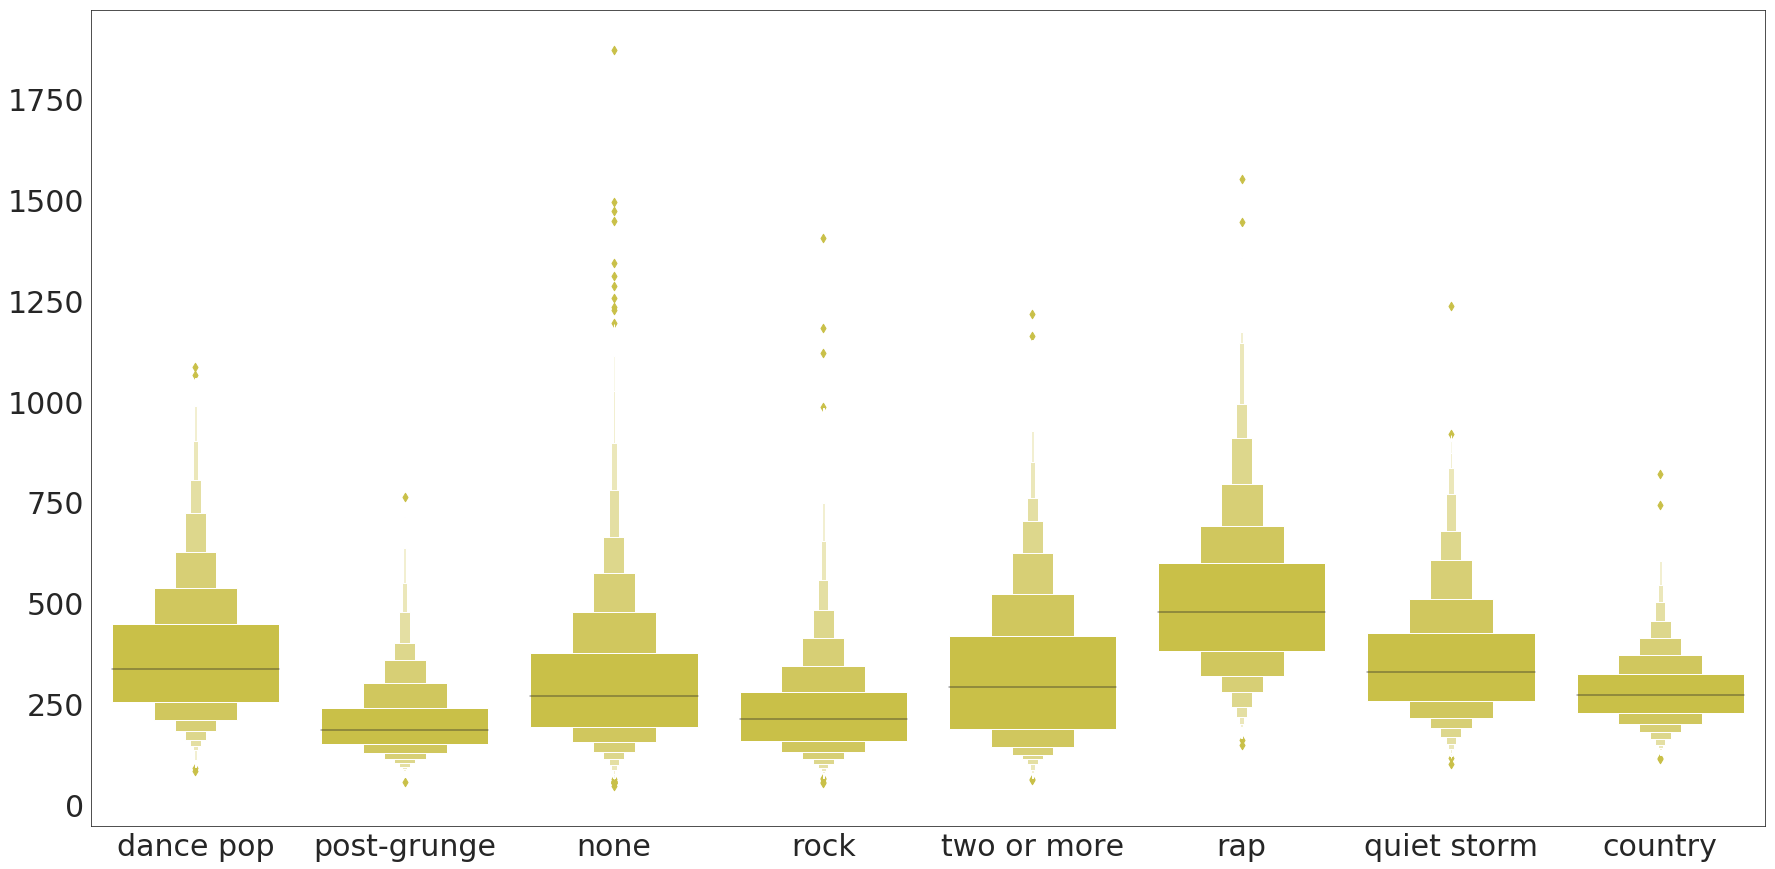

In [72]:
plt.figure(figsize=(30,15))
sns.set_style('white')
sns.boxenplot(main_wfeats['mdg'], 
              main_wfeats['tm_dim_11'],
              color='#dfd232')
plt.xticks(size=30)
plt.yticks(size=30)
plt.xlabel('', 
#            size=20
          )
plt.ylabel('', 
#            size=20
          )
plt.savefig('../images/repetitive_genres.png', transparent=True);

##### Mode vs Valence (with mdg hue)

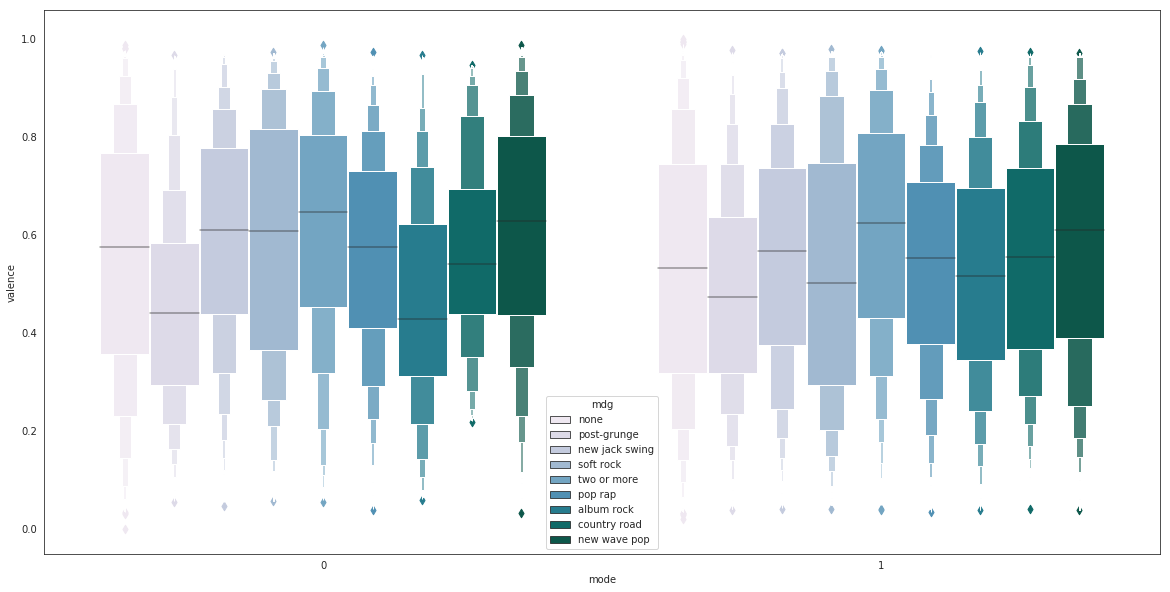

In [75]:
plt.figure(figsize=(20,10))
sns.boxenplot(main_wfeats['mode'], main_wfeats['valence'], hue=main_wfeats['mdg'], palette='PuBuGn');

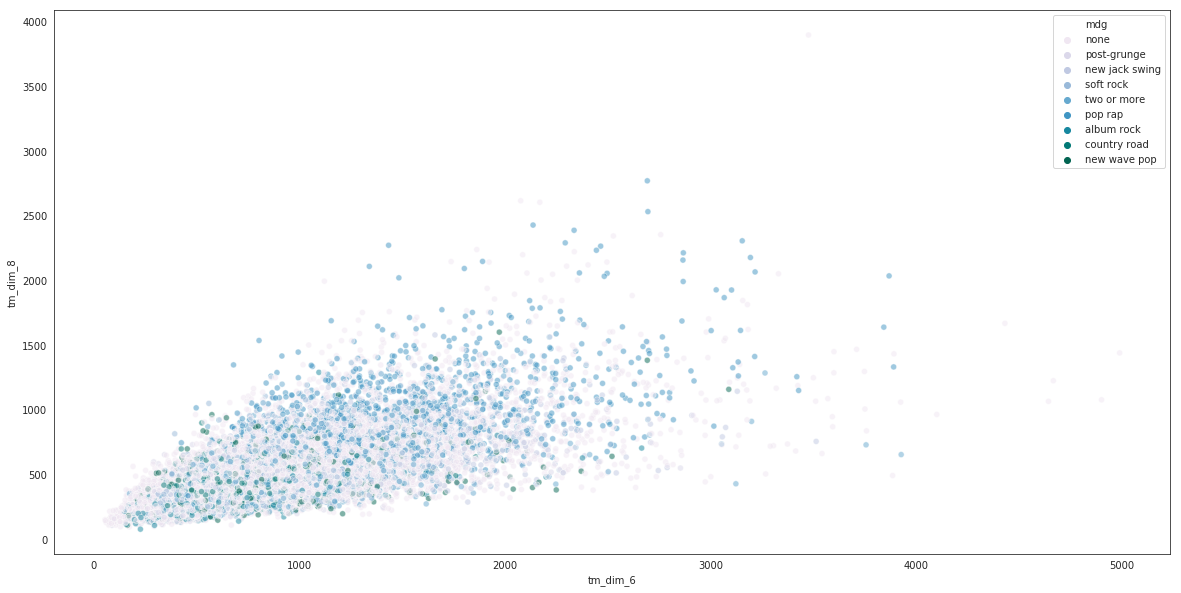

In [78]:
plt.figure(figsize=(20,10))
sns.scatterplot(main_wfeats['tm_dim_6'], main_wfeats['tm_dim_8'], 
                hue=main_wfeats['mdg'], alpha=0.5, palette='PuBuGn', legend='full');

#### Timbre Mean Dimension 7 & 11

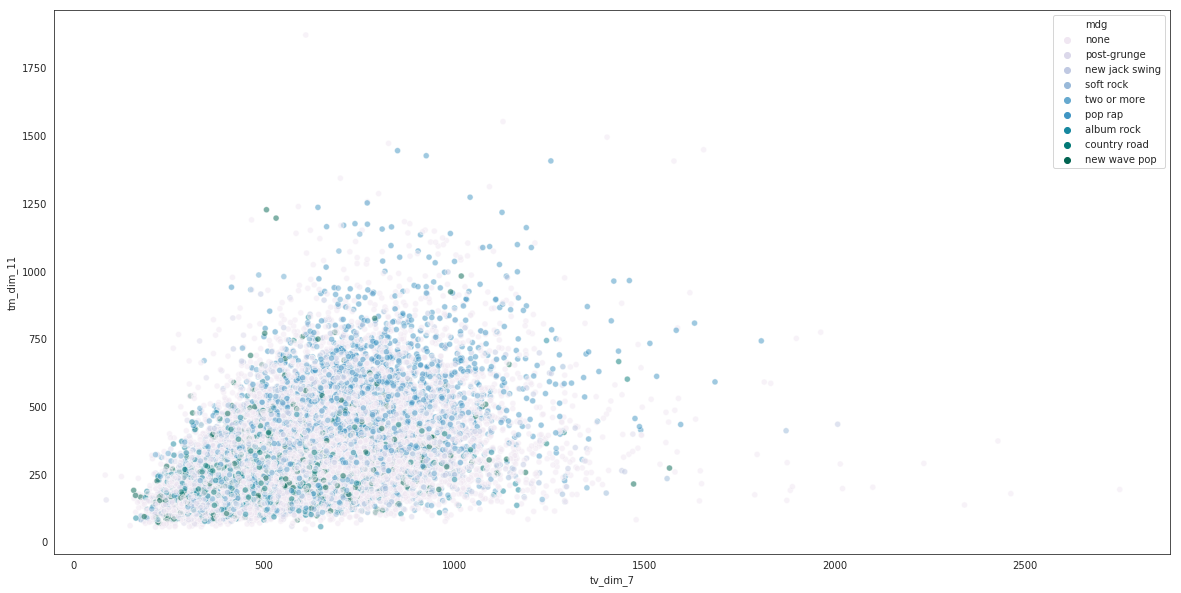

In [81]:
plt.figure(figsize=(20,10))
sns.scatterplot(main_wfeats['tv_dim_7'], main_wfeats['tm_dim_11'], 
                hue=main_wfeats['mdg'], alpha=0.5, palette='PuBuGn', legend='full');

##### Energy vs Loudness with MDG Hue

In [1]:
plt.figure(figsize=(20,10))
sns.scatterplot(main_wfeats['energy'], 
                main_wfeats['loudness'],
                hue=main_wfeats['mdg'],
                alpha=0.5, palette='gist_heat', legend='full');

#### Timbre Mean Dimension 6 vs Danceability (with Energy hue)

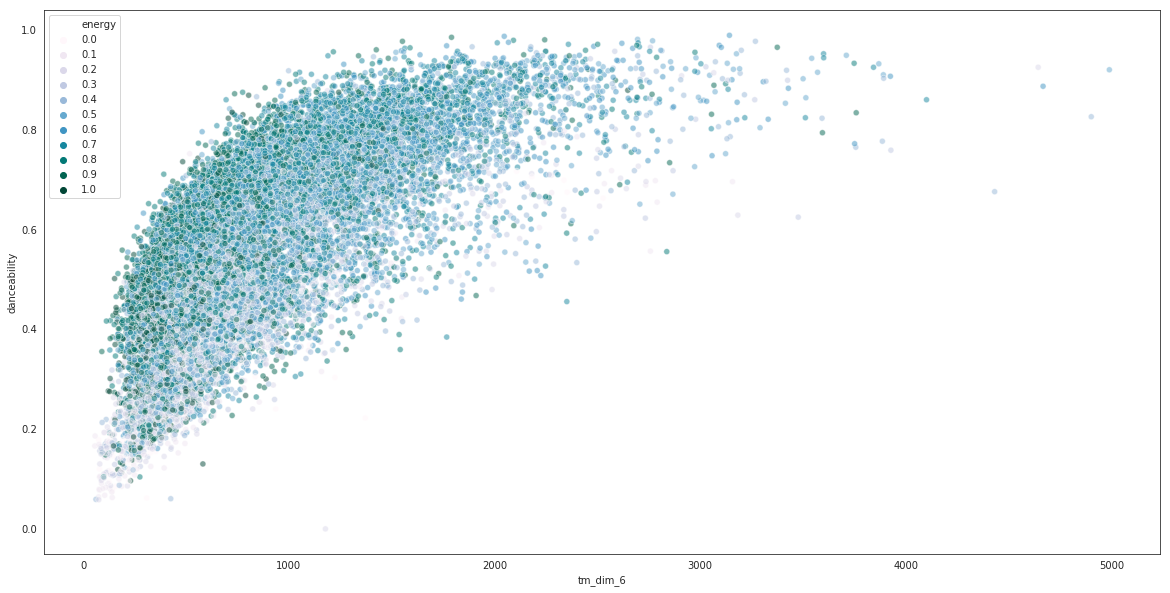

In [97]:
plt.figure(figsize=(20,10))
sns.scatterplot(main_wfeats['tm_dim_6'], main_wfeats['danceability'], 
                hue=main_wfeats['energy'].apply(lambda x: round(x, 1)), alpha=0.5, palette='PuBuGn', legend='full');